In [252]:
import numpy as np
import pandas as pd
from pyecharts import Line,Scatter,Overlap,online
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [8]:
# 加载数据
def loadDataSet():
    dataMat = []
    labelMat = []
    fr = open("./testSet.txt")
    for line in fr.readlines():
        lineArr = line.strip().split()
        dataMat.append([1.0]+[float(arr) for arr in lineArr[:-1]])
        labelMat.append(int(lineArr[-1]))
    return dataMat,labelMat

In [13]:
dataMat,labelMat = loadDataSet()

In [22]:
# 逻辑回归的 logistic function 还有好多
def sigmoid(inX):
    return 1.0/(1+np.exp(-inX)) # np.mat 对象 这里要使用np.exp

In [404]:
# 训练: 使用梯度上升寻找最佳回归系数weights
# 每次使用全部数据训练
def gradientAscent(dataMat,classLabels):
    dataMatrix = np.mat(dataMat)
    labelMat = np.mat(classLabels).transpose()
    m,n = np.shape(dataMatrix)
    alpha = 0.001
    maxCycles = 500
    weights = np.ones((n,1))
    weightsList = np.ones((maxCycles,n,1))
    for k in range(maxCycles):
        weightsList[k] = weights
        h = sigmoid(dataMatrix*weights) # np.mat 对象将运算操作重载为矩阵运算
        error = labelMat - h
        weights = weights + alpha * dataMatrix.transpose()*error # 矩阵运算
    return weights,weightsList

In [411]:
weights,weightsList = gradientAscent(dataMat,labelMat)
weights

matrix([[ 4.12414349],
        [ 0.48007329],
        [-0.6168482 ]])

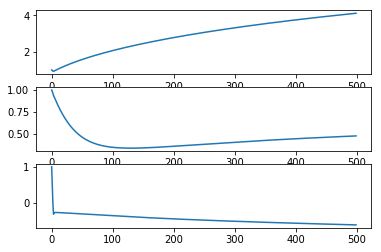

In [412]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(weightsList[:,0])
ax2 = fig.add_subplot(312)
ax2.plot(weightsList[:,1])
ax3 = fig.add_subplot(313)
ax3.plot(weightsList[:,2])

In [93]:
# plot with matplotlib
def plotBestFit(weights):
    dataMat,labelMat = loadDataSet()
    dataArr = np.array(dataMat)
    n = np.shape(dataArr)[0]
    xcord1 = []
    xcord2 = []
    ycord1 = []
    ycord2 = []
    for i in range(n):
        if int(labelMat[i]) == 1:
            xcord1.append(dataArr[i,1])
            ycord1.append(dataArr[i,2])
        else:
            xcord2.append(dataArr[i,1])
            ycord2.append(dataArr[i,2])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1,ycord1,s= 30,c = 'red',marker = 's')
    ax.scatter(xcord2,ycord2,s= 30,c = 'blue')
    x1 = np.arange(-3.0,3.0,0.1)
    x2 = -(weights[0]+ weights[1]*x1)/weights[2]
    ax.plot(x1,x2.getA1()) # 注意这里的维度问题 mat对象即使扁平化也是1*n维度的，getA1() 获得一个数组
    plt.xlabel("X1")
    plt.ylabel('X2')
    plt.show()

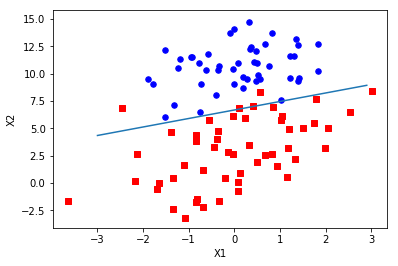

In [90]:
plotBestFit(weights)

In [140]:
# plot with ptecharts
def plotBestFit1(weights):
    dataMat,labelMat = loadDataSet()
    dataArr = np.array(dataMat)
    n = np.shape(dataArr)[0]
    xcord1 = []
    xcord2 = []
    ycord1 = []
    ycord2 = []
    for i in range(n):
        if int(labelMat[i]) == 1:
            xcord1.append(dataArr[i,1])
            ycord1.append(dataArr[i,2])
        else:
            xcord2.append(dataArr[i,1])
            ycord2.append(dataArr[i,2])
    x1 = np.arange(-3.0,3.0,0.1)
    x2 = -(weights[0]+ weights[1]*x1)/weights[2]
    online()
    scatter = Scatter("")
    scatter.add("1",xcord1,ycord1,is_stack = True)
    scatter.add("0",xcord2,ycord2,is_stack = True)
    scatter.add('Decision Boundary scatter',x1,x2.getA1(),is_stack = True)
    line = Line("")
    line.add('Decision Boundary scatter',x1,x2.getA1(),is_symbol_show  =False,is_stack = True)
    overlap = Overlap()
    overlap.add(scatter)
    overlap.add(line)
    return overlap

In [141]:
plotBestFit1(weights)

In [304]:
# plot with seaborn and matplotlib
def plotBestFit2(weights):
    dataMat,labelMat = loadDataSet()
    dataArr = pd.DataFrame(dataMat)
    n = np.shape(dataArr)[0]
    cord = pd.DataFrame(np.ones((n,3)),columns=['x1','x2','label'])
    for i in range(n):
        if int(labelMat[i]) == 1:
            cord.iloc[i,2] = 1
            cord.iloc[i,0] = dataArr.iloc[i,1]
            cord.iloc[i,1] = dataArr.iloc[i,2]
        else:
            cord.iloc[i,2] = 0
            cord.iloc[i,0] = dataArr.iloc[i,1]
            cord.iloc[i,1] = dataArr.iloc[i,2]
    x1 = np.arange(-3.0,3.0,0.1)
    x2 = -(weights[0]+ weights[1]*x1)/weights[2]
    line = pd.DataFrame({'x1':x1,'x2':x2.getA1()})
    ax = sns.lmplot(x='x1',y='x2',data=cord,fit_reg=False,hue ='label')
    ax.ax.plot(x1,x2.getA1()) # 
    return ax

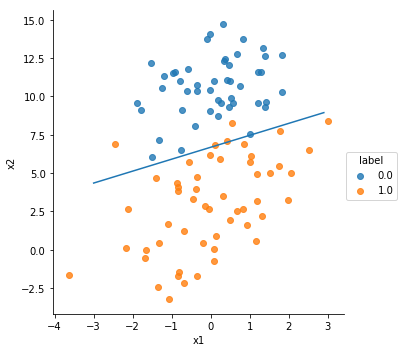

In [307]:
ax =plotBestFit2(weights)

In [433]:
# 随机梯度下降法，指定batchNum为整个数据集的迭代次数
# 每次只使用一个数据更新weights -> 显著降低运算量
# 样本顺序选取
def stocGradAscent0(dataMatrix,classLabels,batchNum = 200):
    m,n = np.shape(dataMatrix)
    alpha = 0.01
    weights = np.ones(n)
    weightsList = np.ones((m*batchNum,n))
    for i in range(m*batchNum):
        weightsList[i] = weights
        i= i%100
        h = sigmoid(sum(dataMatrix[i]*weights)) # 这里是数组与数组相乘，要么用sum 要么用.dot()
        error = classLabels[i] - h
        weights = weights + alpha*error*dataMatrix[i] # error 是一个值，dataMatrix[i]是一个一维向量
    return weights,weightsList

In [434]:
weights0,weightsList0 = stocGradAscent0(np.array(dataMat),labelMat)
weights0

array([ 7.11282257,  0.7158515 , -1.0490159 ])

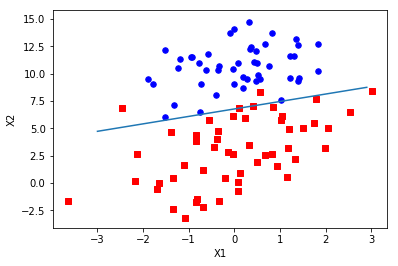

In [435]:
weights0.shape = (3,-1)
plotBestFit(np.mat(weights0))

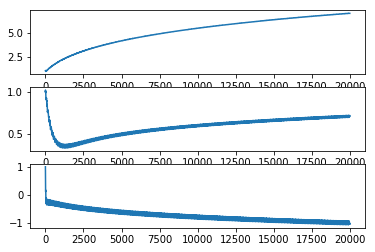

In [436]:
# weights 波动较大 可能由于：数据集中存在不可分点（非线性可分点），导致波动剧烈
# 顺序选取数据，可能导致周期性变动
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(weightsList0[:,0])
ax2 = fig.add_subplot(312)
ax2.plot(weightsList0[:,1])
ax3 = fig.add_subplot(313)
ax3.plot(weightsList0[:,2])

In [450]:
# 随机：每次随机选取一个样本
# 改进1:每次随机选取训练样本 -> 减少周期性波动
# 改进2:动态学习速率  ->  自适应学习速率，但也要保证后期依然有学习速率
def stoGradAscent1(dataMatrix,classLabels,numIter =150):
    m,n = np.shape(dataMatrix)
    weights = np.ones(n)
    weightsList = np.ones((m*numIter,n))
    for j in range(numIter):
        dataIndex = list(range(m))
        for i in range(m):
            weightsList[j*m+i] = weights
            # 动态学习速率
            alpha = 4 / (1.0+j+i)+0.01 # 前面加1防止除0，后面加1防止学习速率消失(永不会为0)
            randIndex = int(np.random.uniform(0,len(dataIndex))) # 随机选取数据
            h = sigmoid(sum(dataMatrix[randIndex]*weights)) 
            error = classLabels[randIndex] - h 
            weights = weights + alpha*error*dataMatrix[randIndex]
            del dataIndex[randIndex]
    return weights,weightsList

In [462]:
weights1,weightsList1 = stoGradAscent1(np.array(dataMat),labelMat,numIter =40)

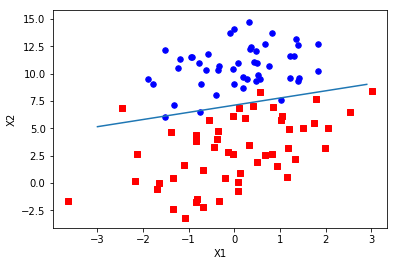

In [463]:
# numIter =40 使用更少的全集合迭代次数，达到和gradAscent（500次迭代）差不多的精度
# 收敛速度快 -> 动态学习速率的原因
weights1.shape = (3,-1)
plotBestFit(np.mat(weights1))

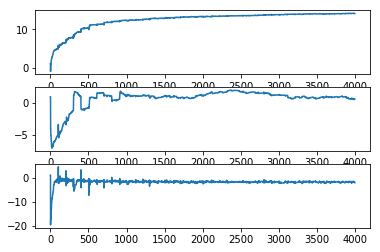

In [458]:
# 没有了周期性波动 -> 随机选取训练数据的原因
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.plot(weightsList1[:,0])
ax2 = fig.add_subplot(312)
ax2.plot(weightsList1[:,1])
ax3 = fig.add_subplot(313)
ax3.plot(weightsList1[:,2])

In [ ]:
# 随机批处理 梯度上升算法
# 改进1: 随机选取一批数据进行更新weights
